# The Validation Set

This notebook explores a subset of the GTSRB (namely the speed signs) to show how the selection of the validation set can affect our expectations when using the net in unseen data.

It covers tensorflow dataset API to load local data:

- how to load local data
- prepare the dataset for training



### References

https://benchmark.ini.rub.de/gtsrb_news.html

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    

https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

https://surfertas.github.io/tensorflow/dl/2018/01/24/tf-data-augmentation.html


In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU, BatchNormalization

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd

BATCH_SIZE = 32
IMAGE_SIZE = 32

### Auxiliary functions for display purposes only

In [2]:
def show_batch(cols, image_batch, label_batch):

    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    

def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    df_cm = pd.DataFrame(conf_mat.numpy(), range(8), range(8))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

    res_correct = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    res_incorrect = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):

        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))

### Auxiliary functions to load images

In [3]:
classNames = np.array(['00000','00001', '00002', '00003', '00004', '00005', '00006', '00007'])

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Local Settings

set the paths to the image data and where the model and logs will be saved.

In [4]:
data_path = 'c:/work/vcpi/gtsrb'
log_and_model_path = 'c:/work/vcpi/dl04/'

### Load images

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(f'{data_path}/train_full/*/*.png')
datasetV1 = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

### Print some data and compute dataset length

In [6]:
for image, label in datasetV1.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

dataset_length = datasetV1.cardinality().numpy()
print(dataset_length)


Image shape:  (32, 32, 3)
Label:  [False False False  True False False False False]
12780


### Prepare the dataset

In [7]:
datasetV1 = datasetV1.cache()
datasetV1 = datasetV1.shuffle(buffer_size = dataset_length)
datasetV1 = datasetV1.batch(batch_size = BATCH_SIZE)
datasetV1 = datasetV1.prefetch(buffer_size = AUTOTUNE)

### Prepare the test set

In [8]:
testset = tf.data.Dataset.list_files(f'{data_path}/test/*/*.png')
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset_length = testset.cardinality().numpy() 
print('number of images: ', testset_length)

testset = testset.batch(batch_size=BATCH_SIZE)
testset_length = testset.cardinality().numpy()
print('number of batches: ',testset_length)

number of images:  4170
number of batches:  131


### Show the first batch

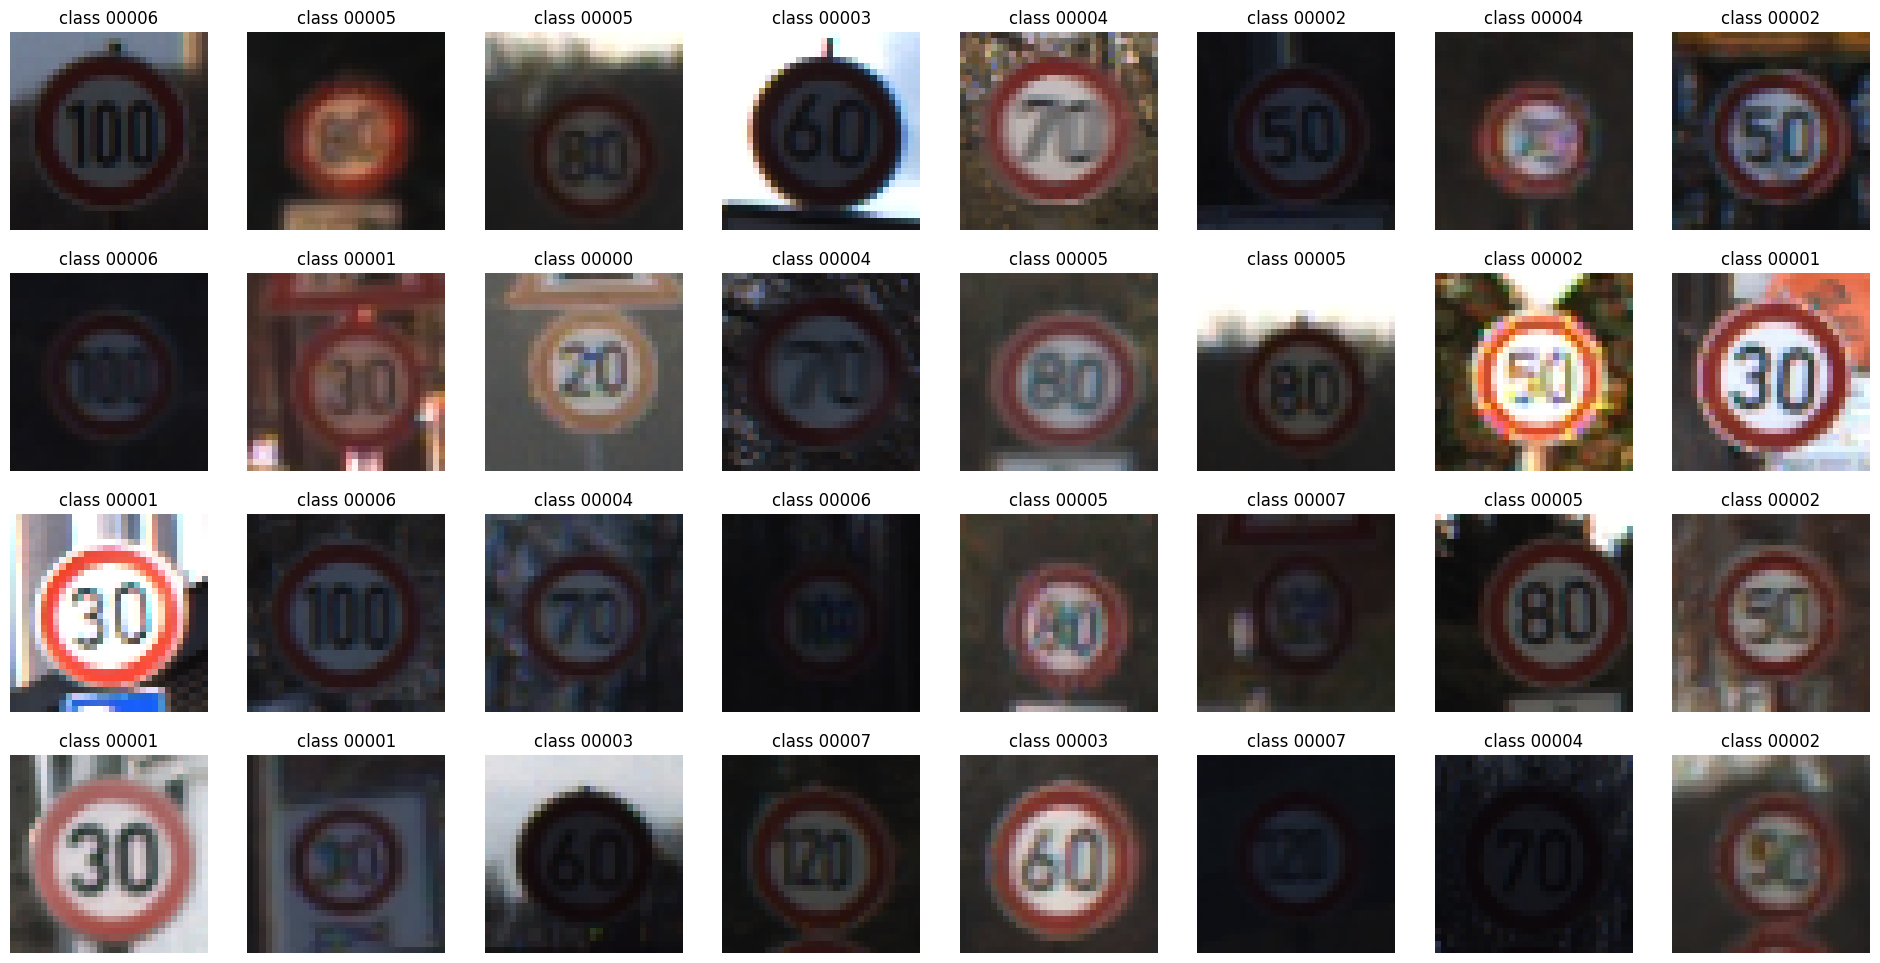

<Figure size 640x480 with 0 Axes>

In [9]:
image_batch, label_batch = next(iter(datasetV1))      
show_batch(8,image_batch, label_batch.numpy()) 

### Define our model

In [10]:
def cnn55D5L2FCLRelu(classCount, imgSize, channels):
    model = Sequential()

    model.add(Input(shape=(imgSize, imgSize, channels)))
    
    model.add(Conv2D(64, (5, 5), padding='same'))         
    model.add(LeakyReLU(alpha=0.01))                                 
    model.add(Conv2D(64, (5, 5) )) 
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5) ) )   
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model




### Create a model and display stats and architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 flatten (Flatten)           (None, 36864)             0

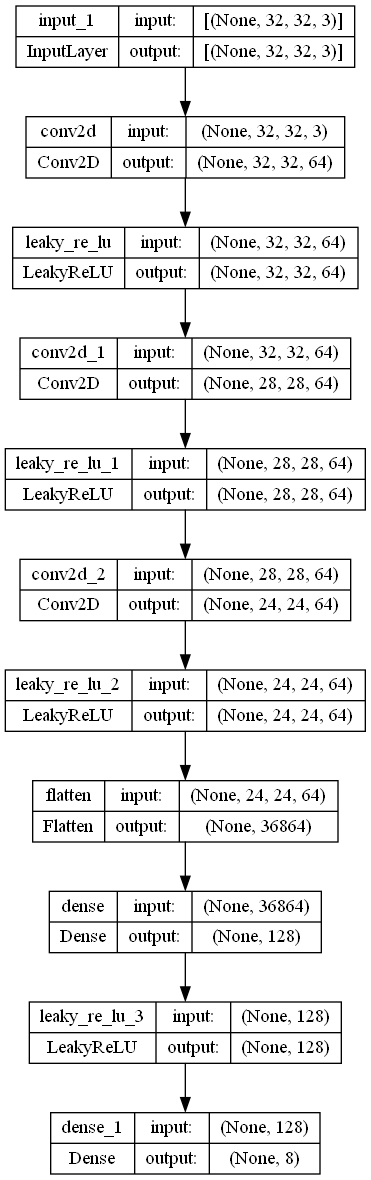

In [11]:
modelV1 = cnn55D5L2FCLRelu(8, 32, 3)

print(modelV1.summary())
tf.keras.utils.plot_model(modelV1, show_shapes=True)

### Split the dataset into training and validation sets

In [12]:
print(dataset_length)
train_size = int(0.8 * dataset_length / BATCH_SIZE)
val_size = int(0.2 * dataset_length / BATCH_SIZE)
train_dataset = datasetV1.take(train_size)
val_dataset = datasetV1.skip(train_size)
print(val_dataset.cardinality())

12780
tf.Tensor(81, shape=(), dtype=int64)


### Callback definition

 - saving model weights at the best epoch considering validation accuracy
 - early stopping when validation accuracy no longer drops for a number of epochs
 - record session to be available on tensorboard.
    
Go to folder where logs are locatted and call >tensorboard --logdir logs

then open a browser and go to:

http://localhost:6006/    

In [13]:
def prepareCallbacks(path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_accuracy',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    return file_path, [checkpointer, earlyStopper, tbCallBack]




### Train model

In [14]:
file_pathV1, callbacksV1 = prepareCallbacks('valV1')

historyV1 = modelV1.fit(datasetV1,
          epochs=20, 
          validation_data = val_dataset, 
          callbacks=callbacksV1)

Epoch 1/20
400/400 [==============================] - ETA: 0s - loss: 0.8647 - accuracy: 0.7099
Epoch 1: val_accuracy improved from -inf to 0.93429, saving model to c:/work/vcpi/dl04//valV1\cp.ckpt
400/400 [==============================] - 15s 20ms/step - loss: 0.8647 - accuracy: 0.7099 - val_loss: 0.2465 - val_accuracy: 0.9343
Epoch 2/20
392/400 [============================>.] - ETA: 0s - loss: 0.1780 - accuracy: 0.9503
Epoch 2: val_accuracy improved from 0.93429 to 0.97201, saving model to c:/work/vcpi/dl04//valV1\cp.ckpt
400/400 [==============================] - 4s 10ms/step - loss: 0.1760 - accuracy: 0.9509 - val_loss: 0.1032 - val_accuracy: 0.9720
Epoch 3/20
395/400 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9740
Epoch 3: val_accuracy improved from 0.97201 to 0.98289, saving model to c:/work/vcpi/dl04//valV1\cp.ckpt
400/400 [==============================] - 4s 10ms/step - loss: 0.0962 - accuracy: 0.9743 - val_loss: 0.0583 - val_accuracy: 0.9829
Epo

### Show graphs for accuracy and loss history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


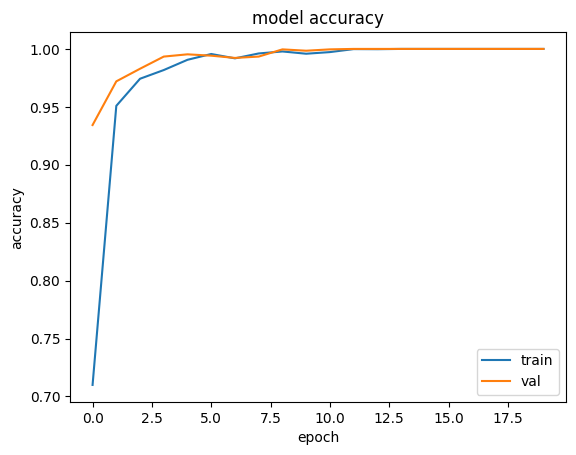

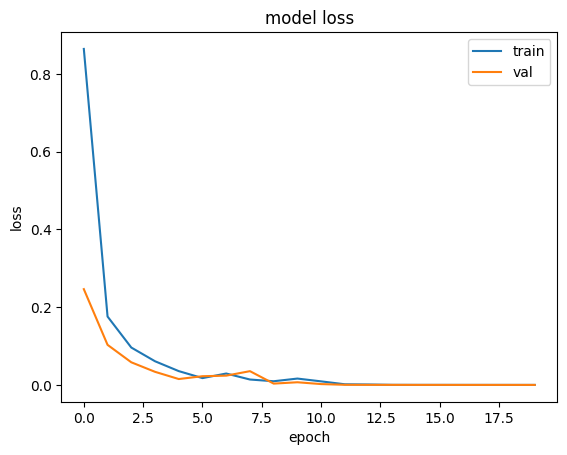

In [15]:
show_history(historyV1)

### Load weights for best epoch and evaluate model

Notice how the validation set accuracy differs from the test set accuracy. Why?

In [16]:
modelV1.load_weights(file_pathV1)
evalV1 = modelV1.evaluate(testset, verbose=2)
print(evalV1)

valV1 = modelV1.evaluate(val_dataset,verbose=2)

131/131 - 1s - loss: 0.3264 - accuracy: 0.9494 - 688ms/epoch - 5ms/step
[0.3263600170612335, 0.9494004845619202]
81/81 - 0s - loss: 4.8156e-04 - accuracy: 1.0000 - 260ms/epoch - 3ms/step


# Manual partitioning of dataset 

Taking into account the features of the GTSRB we explore an alternative way of partitioning the dataset into training and validation sets.

Main goal: to have validation accuracy as a better prediction of test set accuracy

In [17]:
listset = tf.data.Dataset.list_files(f'{data_path}/train/*/*.png')
trainsetV2 = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
trainsetV2 = trainsetV2.cache()
trainsetV2 = trainsetV2.shuffle(buffer_size=10200)
trainsetV2 = trainsetV2.batch(batch_size=BATCH_SIZE)
trainsetV2 = trainsetV2.prefetch(buffer_size=AUTOTUNE)


listset = tf.data.Dataset.list_files(f'{data_path}/val/*/*.png')
valset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
valset = valset.cache()
valset = valset.batch(batch_size=BATCH_SIZE)
valset = valset.prefetch(buffer_size=AUTOTUNE)



### Build the model and train it

In [18]:
modelV2 = cnn55D5L2FCLRelu(8, 32, 3)

file_pathV2, callbacksV2 = prepareCallbacks('valV2')

historyV2 = modelV2.fit(trainsetV2, 
          epochs=20, 
          validation_data = valset, 
          callbacks = callbacksV2)

Epoch 1/20
319/319 [==============================] - ETA: 0s - loss: 0.9609 - accuracy: 0.6730
Epoch 1: val_accuracy improved from -inf to 0.84341, saving model to c:/work/vcpi/dl04//valV2\cp.ckpt
319/319 [==============================] - 5s 11ms/step - loss: 0.9609 - accuracy: 0.6730 - val_loss: 0.4821 - val_accuracy: 0.8434
Epoch 2/20
319/319 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9410
Epoch 2: val_accuracy improved from 0.84341 to 0.85930, saving model to c:/work/vcpi/dl04//valV2\cp.ckpt
319/319 [==============================] - 3s 10ms/step - loss: 0.2100 - accuracy: 0.9410 - val_loss: 0.4087 - val_accuracy: 0.8593
Epoch 3/20
316/319 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9720
Epoch 3: val_accuracy did not improve from 0.85930
319/319 [==============================] - 3s 9ms/step - loss: 0.1012 - accuracy: 0.9719 - val_loss: 0.4975 - val_accuracy: 0.8426
Epoch 4/20
319/319 [==============================] - ETA: 

### Show history and accuracies with new partition

The validation accuracy is further away from the training accuracy, but at the same time it is a better predictor of the test set accuracy.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


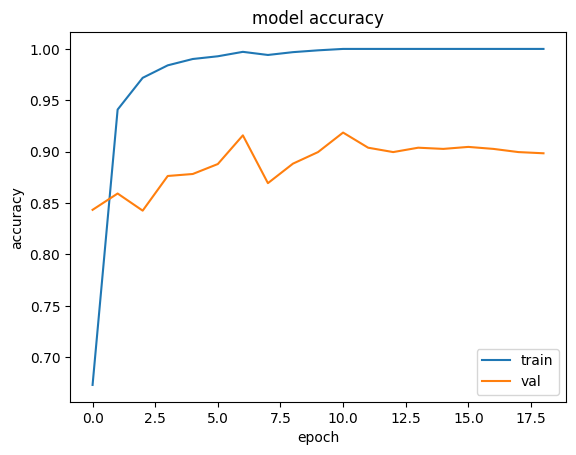

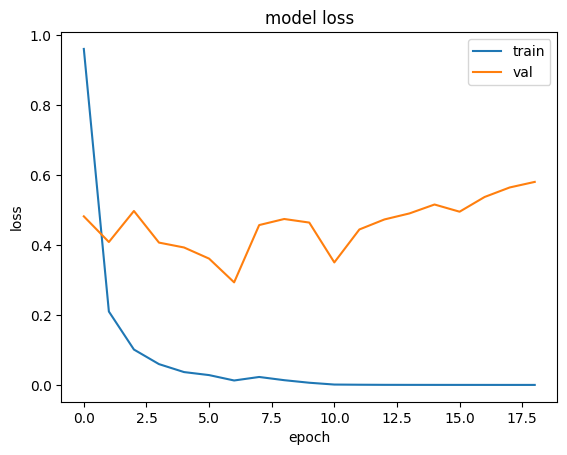

In [19]:
show_history(historyV2)

In [20]:
modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(testset, verbose=2)
print(evalV2)
valV2 = modelV2.evaluate(valset, verbose=2)

131/131 - 1s - loss: 0.3952 - accuracy: 0.9396 - 744ms/epoch - 6ms/step
[0.3951963186264038, 0.9395683407783508]
81/81 - 0s - loss: 0.3504 - accuracy: 0.9186 - 287ms/epoch - 4ms/step


### Compare both models 

Comparison for both test and validation set accuracies

Note that it may be the case that, when comparing both models, the test set accuracy decreases in the second model. 

This is due to the fact that we now have in less data to train. 

Although the validation sets had approximatelly the same size when training both models, in the first case random images were taken from the dataset, leaving most sequences intact.

In the second situation complete sequences were taken from the training set, providing for less information during training.

[0.0004815610300283879, 1.0] [0.3263600170612335, 0.9494004845619202] [0.3504061996936798, 0.9186046719551086] [0.3951963186264038, 0.9395683407783508]


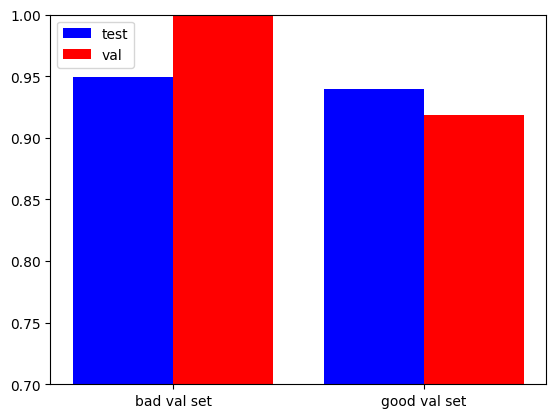

In [21]:
print(valV1, evalV1, valV2, evalV2)

show_accuracies()

### Evaluating the model on a single image

In [22]:
import PIL
from PIL import Image

# read image
im = Image.open(f'{data_path}/test/00000/s01279.png')

# resize to (32,32)
im = im.resize((32,32))

# convert to numpy
numpy_image = np.asarray(im)

# expand to include batch info
numpy_image = np.expand_dims(numpy_image, axis = 0)

# predict
in_pred = modelV2.predict([numpy_image])
print(in_pred)

1/1 [==============================] - 0s 90ms/step
[[1. 0. 0. 0. 0. 0. 0. 0.]]


In [23]:
data, = testset.take(1)

# data[0] are the batch images; data[1] are the labels

# this shows the first 5 labels for the batch
print (data[1][:5])

#predict the first image
in_pred = modelV2.predict(np.expand_dims(data[0][0], axis = 0))
print(in_pred)

tf.Tensor(
[[False False  True False False False False False]
 [False False False False  True False False False]
 [False False False False False  True False False]
 [False False False False  True False False False]
 [False False False  True False False False False]], shape=(5, 8), dtype=bool)
1/1 [==============================] - 0s 51ms/step
[[2.99320495e-21 1.43135743e-08 1.00000000e+00 8.11512687e-17
  2.47638634e-13 1.64115198e-17 1.00445693e-13 4.97448739e-19]]


### Check the models performance on a few batches

1/1 [==============================] - 0s 16ms/step


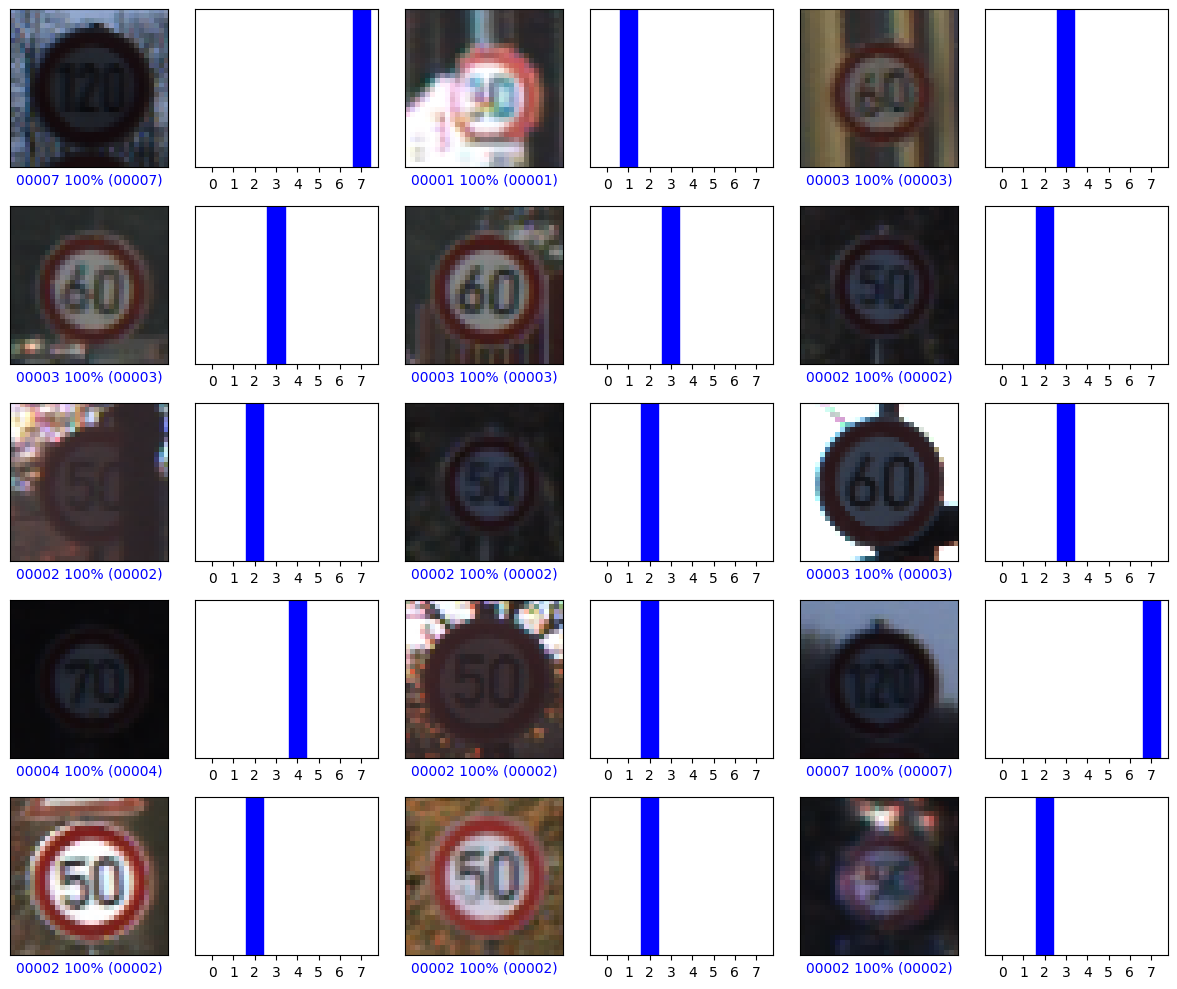

1/1 [==============================] - 0s 16ms/step


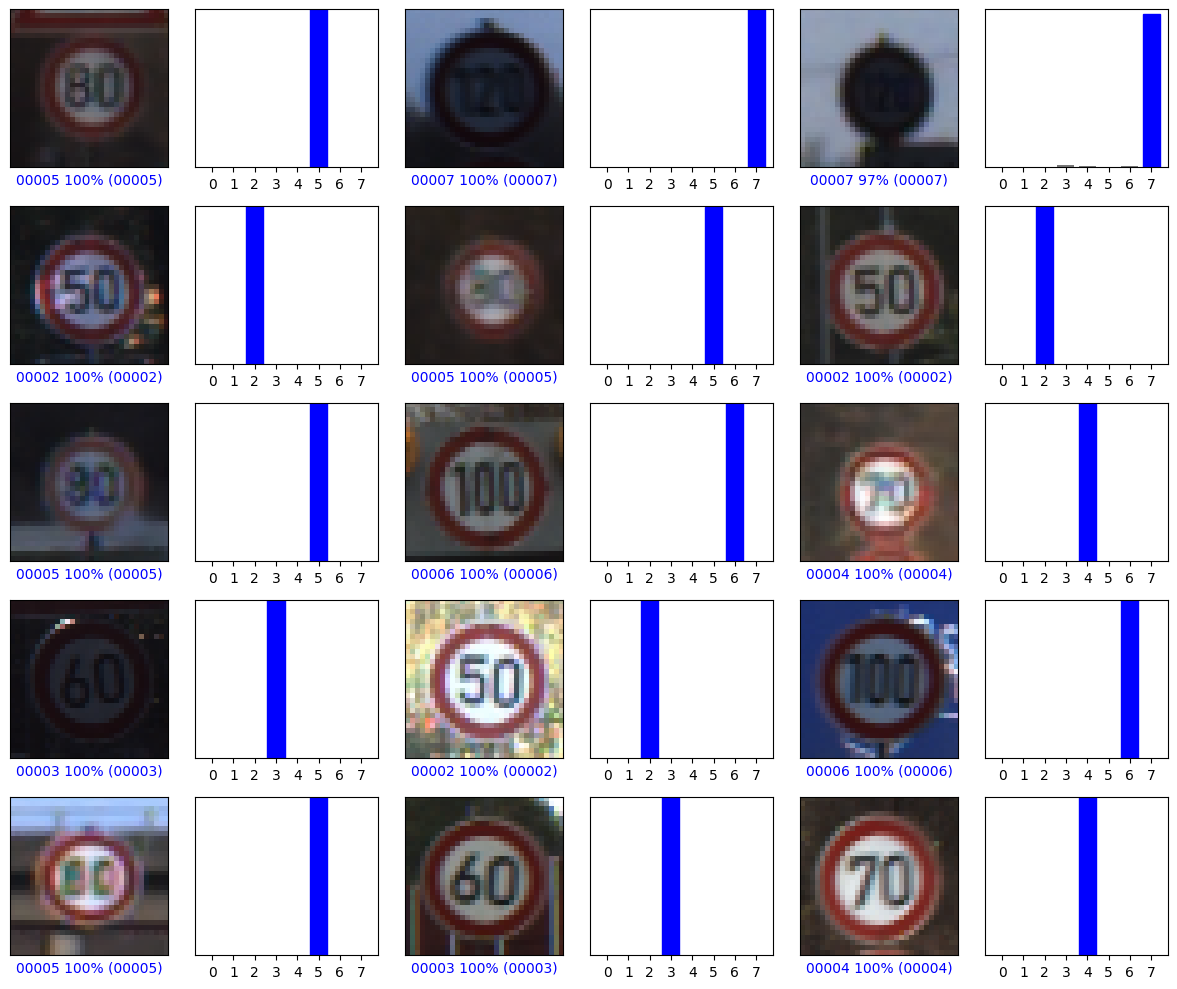

In [24]:
for images, labels in testset.take(2):  # take n batches of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelV2.predict(numpy_images)  
    plot_predictions(preds, numpy_labels, numpy_images, 5, 3)
    

### checking some misclassified images

1/1 [==============================] - 0s 15ms/step


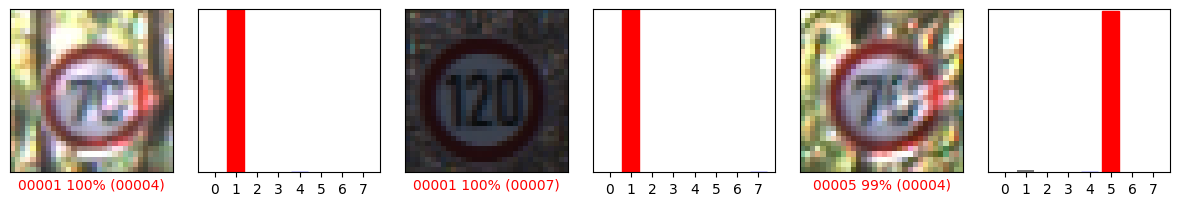

1/1 [==============================] - 0s 16ms/step


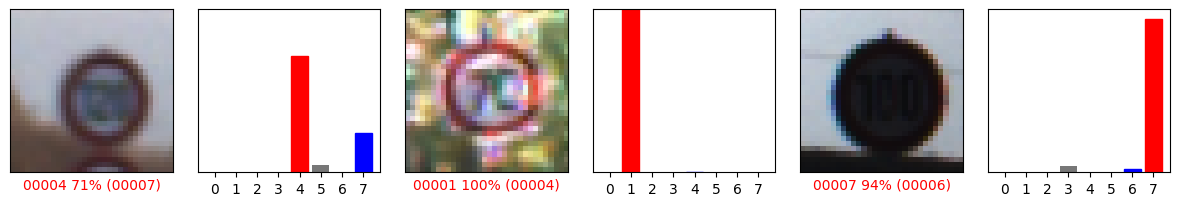

1/1 [==============================] - 0s 15ms/step


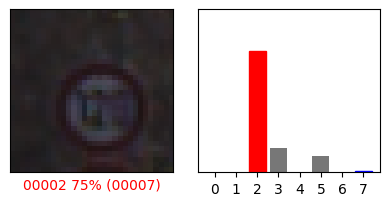

1/1 [==============================] - 0s 16ms/step


<Figure size 1200x1000 with 0 Axes>

1/1 [==============================] - 0s 15ms/step


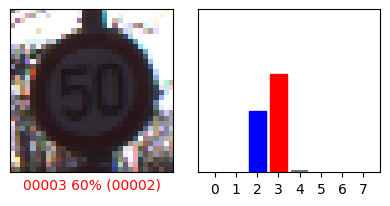

1/1 [==============================] - 0s 16ms/step


<Figure size 1200x1000 with 0 Axes>

1/1 [==============================] - 0s 15ms/step


<Figure size 1200x1000 with 0 Axes>

1/1 [==============================] - 0s 16ms/step


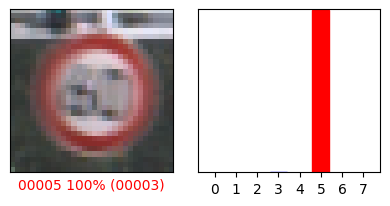

1/1 [==============================] - 0s 14ms/step


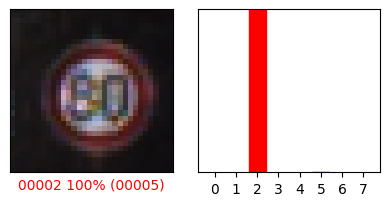

1/1 [==============================] - 0s 19ms/step


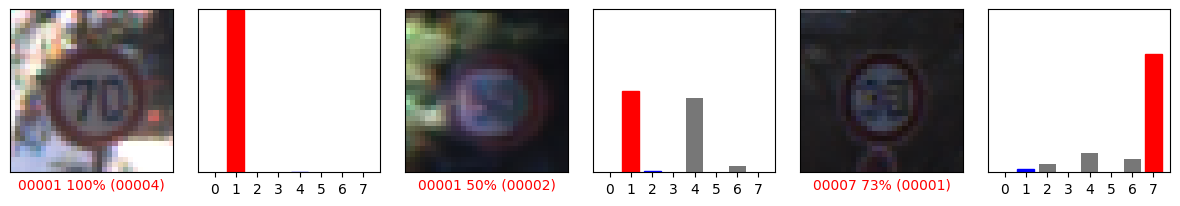

In [25]:
for images, labels in testset.take(10):  # take 10 batches of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelV2.predict(numpy_images)  
    show_misclassified(preds, numpy_labels, numpy_images, 5, 3)



### Confusion Matrix

The matrix columns represent the prediction labels and the rows represent the real labels.

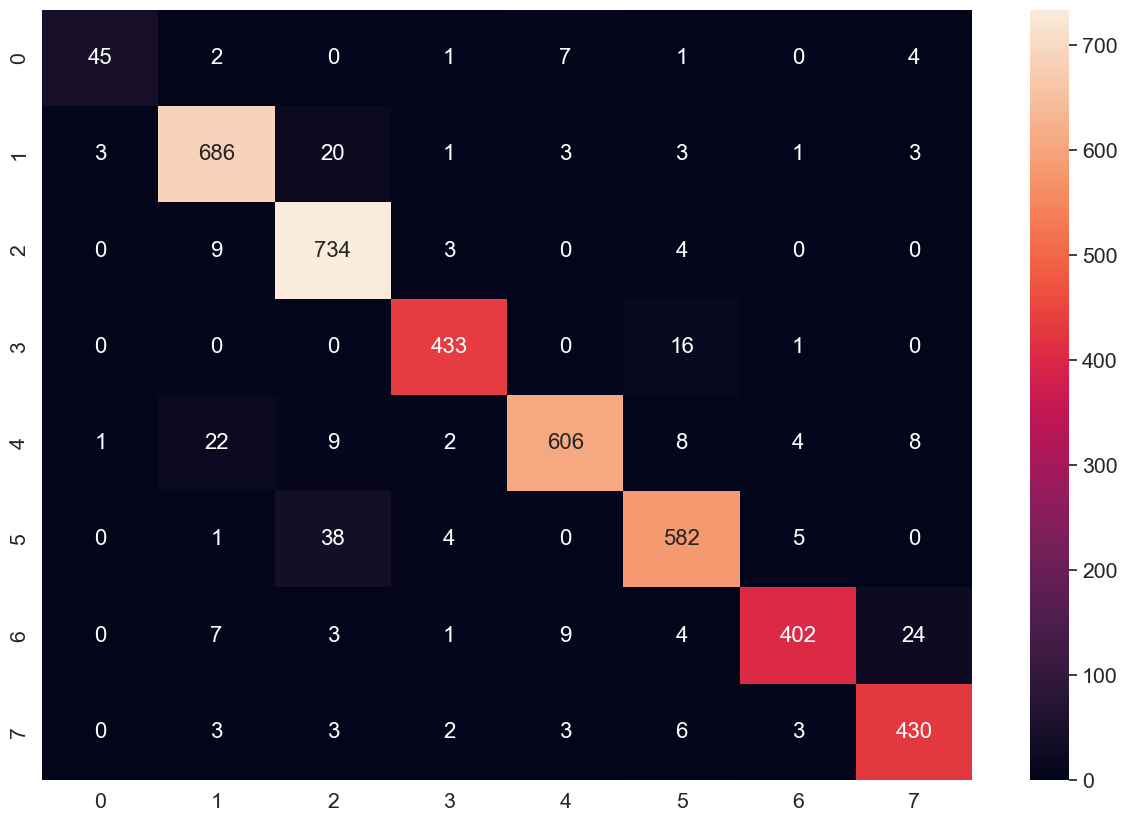

class:  0  total images:  60  % correct:  0.75
class:  1  total images:  720  % correct:  0.9527777777777777
class:  2  total images:  750  % correct:  0.9786666666666667
class:  3  total images:  450  % correct:  0.9622222222222222
class:  4  total images:  660  % correct:  0.9181818181818182
class:  5  total images:  630  % correct:  0.9238095238095239
class:  6  total images:  450  % correct:  0.8933333333333333
class:  7  total images:  450  % correct:  0.9555555555555556


In [26]:
show_confusion_matrix(modelV2, testset)